This notebook shows how to apply Neural Networks to predict the global temperature, based on the time series of CO2 & CH4.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import torch
import torch.nn as nn
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
cwd = os.getcwd()
ds1 = xr.open_dataset("lightning_era5_merged_july2024.nc")

## Use Neural Networks (NN) for lightning prediction

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

In [4]:
# Training set
d0_train = '2024-07-01T00:00:00'
d1_train = '2024-07-21T00:00:00'
X_train_xr = ds1.sel(time=slice(d0_train,d1_train))
y_train_xr = ds1.sel(time=slice(d0_train,d1_train))

# Test set
d0_test = '2024-07-21T00:00:00'
d1_test = '2024-07-31T00:00:00'
X_test_xr = ds1.sel(time=slice(d0_test,d1_test))
y_test_xr = ds1.sel(time=slice(d0_test,d1_test))

In [5]:
X_train = X_train_xr['total_column_water_vapour'].stack({"stacked": ("latitude", "longitude")}).to_numpy()
X_test = X_test_xr['total_column_water_vapour'].stack({"stacked": ("latitude", "longitude")}).to_numpy()

y_train = y_train_xr['lightning_density'].stack({"stacked": ("latitude", "longitude")}).to_numpy()
y_test = y_test_xr['lightning_density'].stack({"stacked": ("latitude", "longitude")}).to_numpy()

#### Data normalization

Let's normalize the input predictors by the mean & std

In [6]:
# Standardization
mean, std = X_train.mean(), X_train.std()

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Convert to binary classification: 1 if lightning present, 0 otherwise
y_train_binary = (y_train > 0).astype(np.float32)
y_test_binary = (y_test > 0).astype(np.float32)

# Calculate class weights for imbalanced data
pos_weight = (y_train_binary == 0).sum() / (y_train_binary == 1).sum()
print(f"\nClass imbalance ratio (neg/pos): {pos_weight:.2f}")
print(f"  This means there are {pos_weight:.0f}x more non-lightning pixels than lightning pixels")

# Convert to PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train),
                                               torch.FloatTensor(y_train_binary))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test),
                                             torch.FloatTensor(y_test_binary))

# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

### 2. Define the NN structure

<!-- 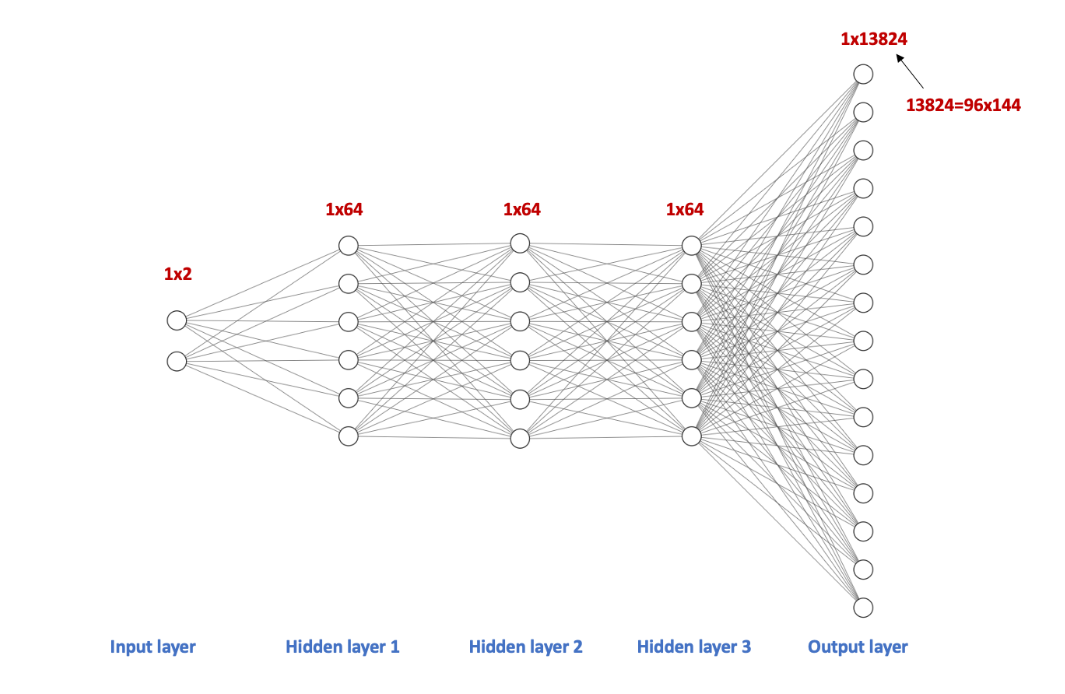 -->

Here are the hyperparameters for the NN training, such as the number of neurons per layer, learning rate, etc. Note that these hyperparameters here are for demonstration purposes only - they are not optimized.  

In [7]:
# set hyperparameters
n_neuron       = 64
activation     = 'Sigmoid'#'ReLU' #'Linear', 'Tanh'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
N_layers       = 2 # number of hidden layers

In [8]:
# Create data loaders for batched training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

In [9]:
layers = []
layers.append(nn.Linear(X_train.shape[1], n_neuron))
layers.append(getattr(nn, activation)())
layers.append(nn.Dropout(0.2))  # Add dropout for regularization

for n in range(N_layers-1):
    layers.append(nn.Linear(n_neuron, n_neuron))
    layers.append(getattr(nn, activation)())
    layers.append(nn.Dropout(0.2))

layers.append(nn.Linear(n_neuron, y_train_binary.shape[1]))

model = nn.Sequential(*layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#criterion = nn.MSELoss()
pos_weight_tensor = torch.ones(y_train_binary.shape[1]) * pos_weight
criterion = nn.BCEWithLogitsLoss()

In [10]:
print(model)

Sequential(
  (0): Linear(in_features=39621, out_features=64, bias=True)
  (1): Sigmoid()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): Sigmoid()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=64, out_features=39621, bias=True)
)


In [11]:
model.to(device)

Sequential(
  (0): Linear(in_features=39621, out_features=64, bias=True)
  (1): Sigmoid()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): Sigmoid()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=64, out_features=39621, bias=True)
)

### 3. Train & save the NN model

Here we stop early, if the validation loss does not improve for 20 epochs, to avoid over-fitting.

In [12]:
best_val_loss = float('inf')
patience_counter = 0
patience = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
   # training
   model.train()
   train_loss = 0.0
   for batch_X, batch_y in train_loader:
       batch_X = batch_X.to(device)
       batch_y = batch_y.to(device)
       # forward pass
       optimizer.zero_grad()
       outputs = model(batch_X)
       loss = criterion(outputs, batch_y)
       # backward pass
       loss.backward()
       optimizer.step()
       train_loss += loss.item()

    # validation
   model.eval()
   val_loss = 0.0
   with torch.no_grad():
       for batch_X, batch_y in val_loader:
           batch_X = batch_X.to(device)
           batch_y = batch_y.to(device)
           
           outputs = model(batch_X)
           loss = criterion(outputs, batch_y)
           val_loss += loss.item()
   
   train_loss /= len(train_loader)
   val_loss /= len(val_loader)

   train_losses.append(train_loss)
   val_losses.append(val_loss)
   
   print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
   
   if val_loss < best_val_loss:
       best_val_loss = val_loss
       patience_counter = 0
   else:
       patience_counter += 1
       if patience_counter >= patience:
           print(f'Early stopping at epoch {epoch+1}')
           break

Epoch 1/50, Train Loss: 0.6710, Val Loss: 0.6207
Epoch 2/50, Train Loss: 0.5882, Val Loss: 0.5372
Epoch 3/50, Train Loss: 0.5047, Val Loss: 0.4524
Epoch 4/50, Train Loss: 0.4209, Val Loss: 0.3705
Epoch 5/50, Train Loss: 0.3431, Val Loss: 0.2965
Epoch 6/50, Train Loss: 0.2735, Val Loss: 0.2344
Epoch 7/50, Train Loss: 0.2167, Val Loss: 0.1857
Epoch 8/50, Train Loss: 0.1734, Val Loss: 0.1496
Epoch 9/50, Train Loss: 0.1410, Val Loss: 0.1238
Epoch 10/50, Train Loss: 0.1178, Val Loss: 0.1057
Epoch 11/50, Train Loss: 0.1024, Val Loss: 0.0929
Epoch 12/50, Train Loss: 0.0911, Val Loss: 0.0838
Epoch 13/50, Train Loss: 0.0827, Val Loss: 0.0772
Epoch 14/50, Train Loss: 0.0758, Val Loss: 0.0723
Epoch 15/50, Train Loss: 0.0709, Val Loss: 0.0685
Epoch 16/50, Train Loss: 0.0676, Val Loss: 0.0655
Epoch 17/50, Train Loss: 0.0647, Val Loss: 0.0632
Epoch 18/50, Train Loss: 0.0622, Val Loss: 0.0613
Epoch 19/50, Train Loss: 0.0609, Val Loss: 0.0597
Epoch 20/50, Train Loss: 0.0586, Val Loss: 0.0583
Epoch 21/

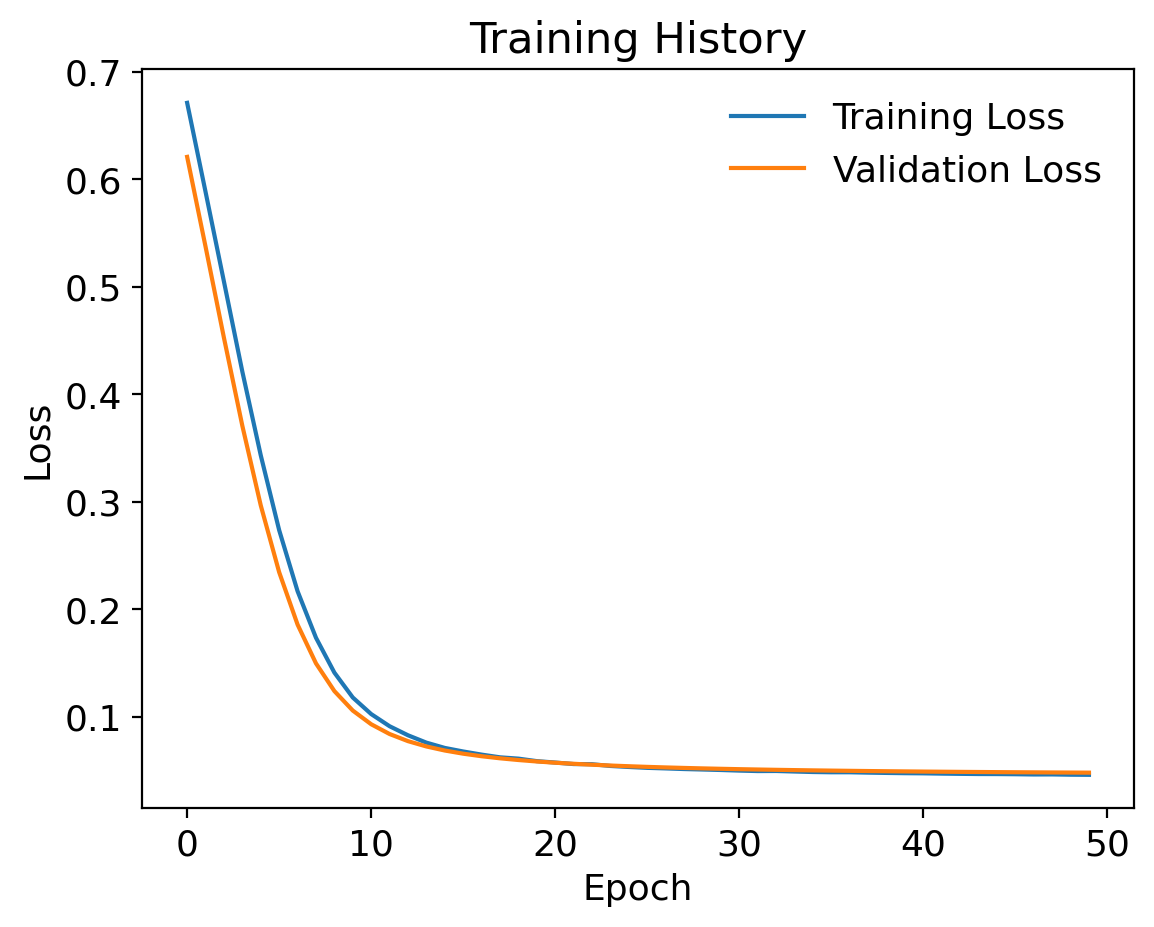

In [13]:
plot_history(train_losses, val_losses)

we can save the trained model as the `.h5` file.

In [14]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [15]:
# Save the entire model to a pth file.
torch.save(model, os.path.join(model_path, 'NN_model.pth'))

### 4. Evaluate the trained model

Now let's evaluate the trained NN on the test set, by comparing the NN predictions against the tas originally simulated under the ssp245 scenario. 

In [16]:
# reload the saved model
model = torch.load(os.path.join(model_path, 'NN_model.pth'), weights_only=False)
model.to(device).eval()

Sequential(
  (0): Linear(in_features=39621, out_features=64, bias=True)
  (1): Sigmoid()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): Sigmoid()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=64, out_features=39621, bias=True)
)

In [17]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

model.eval()
predictions = []
targets = []
with torch.no_grad():
   for batch_X, batch_y in test_loader:
       batch_X = batch_X.to(device)
       outputs = model(batch_X)
       probs = torch.sigmoid(outputs)
       predictions.append(outputs.cpu().numpy())
       targets.append(batch_y.cpu().numpy())

y_test_pred_probs = np.concatenate(predictions, axis=0)
y_test_true = np.concatenate(targets, axis=0)

In [26]:
# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Flatten for metrics
y_test_true_flat = y_test_true.flatten()
y_test_pred_probs_flat = y_test_pred_probs.flatten()

# Binary predictions with threshold
threshold = 0.5
y_test_pred_binary_flat = (y_test_pred_probs_flat >= threshold).astype(np.float32)

# Calculate metrics
accuracy = accuracy_score(y_test_true_flat, y_test_pred_binary_flat)
precision = precision_score(y_test_true_flat, y_test_pred_binary_flat, zero_division=0)
recall = recall_score(y_test_true_flat, y_test_pred_binary_flat, zero_division=0)
f1 = f1_score(y_test_true_flat, y_test_pred_binary_flat, zero_division=0)
auc_roc = roc_auc_score(y_test_true_flat, y_test_pred_probs_flat)

print(f"\nTest Set Metrics:")
print(f"  Accuracy:  {accuracy:.4f} ({100*accuracy:.2f}%)")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print(f"  AUC-ROC:   {auc_roc:.4f}")


Test Set Metrics:
  Accuracy:  0.9933 (99.33%)
  Precision: 0.5206
  Recall:    0.0039
  F1 Score:  0.0078
  AUC-ROC:   0.8497


In [27]:
# Reshape predictions for visualization
y_test_pred_binary = (y_test_pred_probs >= threshold).astype(np.float32)
y_test_pred_binary_reshaped = y_test_pred_binary.reshape(y_test_pred_binary.shape[0], 141, 281)
y_test_pred_probs_reshaped = y_test_pred_probs.reshape(y_test_pred_probs.shape[0], 141, 281)

# Create xarray Dataset for predictions
y_test_pred_xr = xr.Dataset(
    coords={
        'time': X_test_xr.time.values, 
        'latitude': X_test_xr.latitude.values, 
        'longitude': X_test_xr.longitude.values
    },
    data_vars=dict(
        lightning_probability=(['time', 'latitude', 'longitude'], y_test_pred_probs_reshaped),
        lightning_binary=(['time', 'latitude', 'longitude'], y_test_pred_binary_reshaped)
    )
)

# Binarize actual data for fair comparison
y_test_binary_xr = (y_test_xr.lightning_density > 0).astype(float)

First we check whether the ML model can capture the spatial distribution of global temperature


Saved spatial predictions to 'nn_predictions_spatial.png'


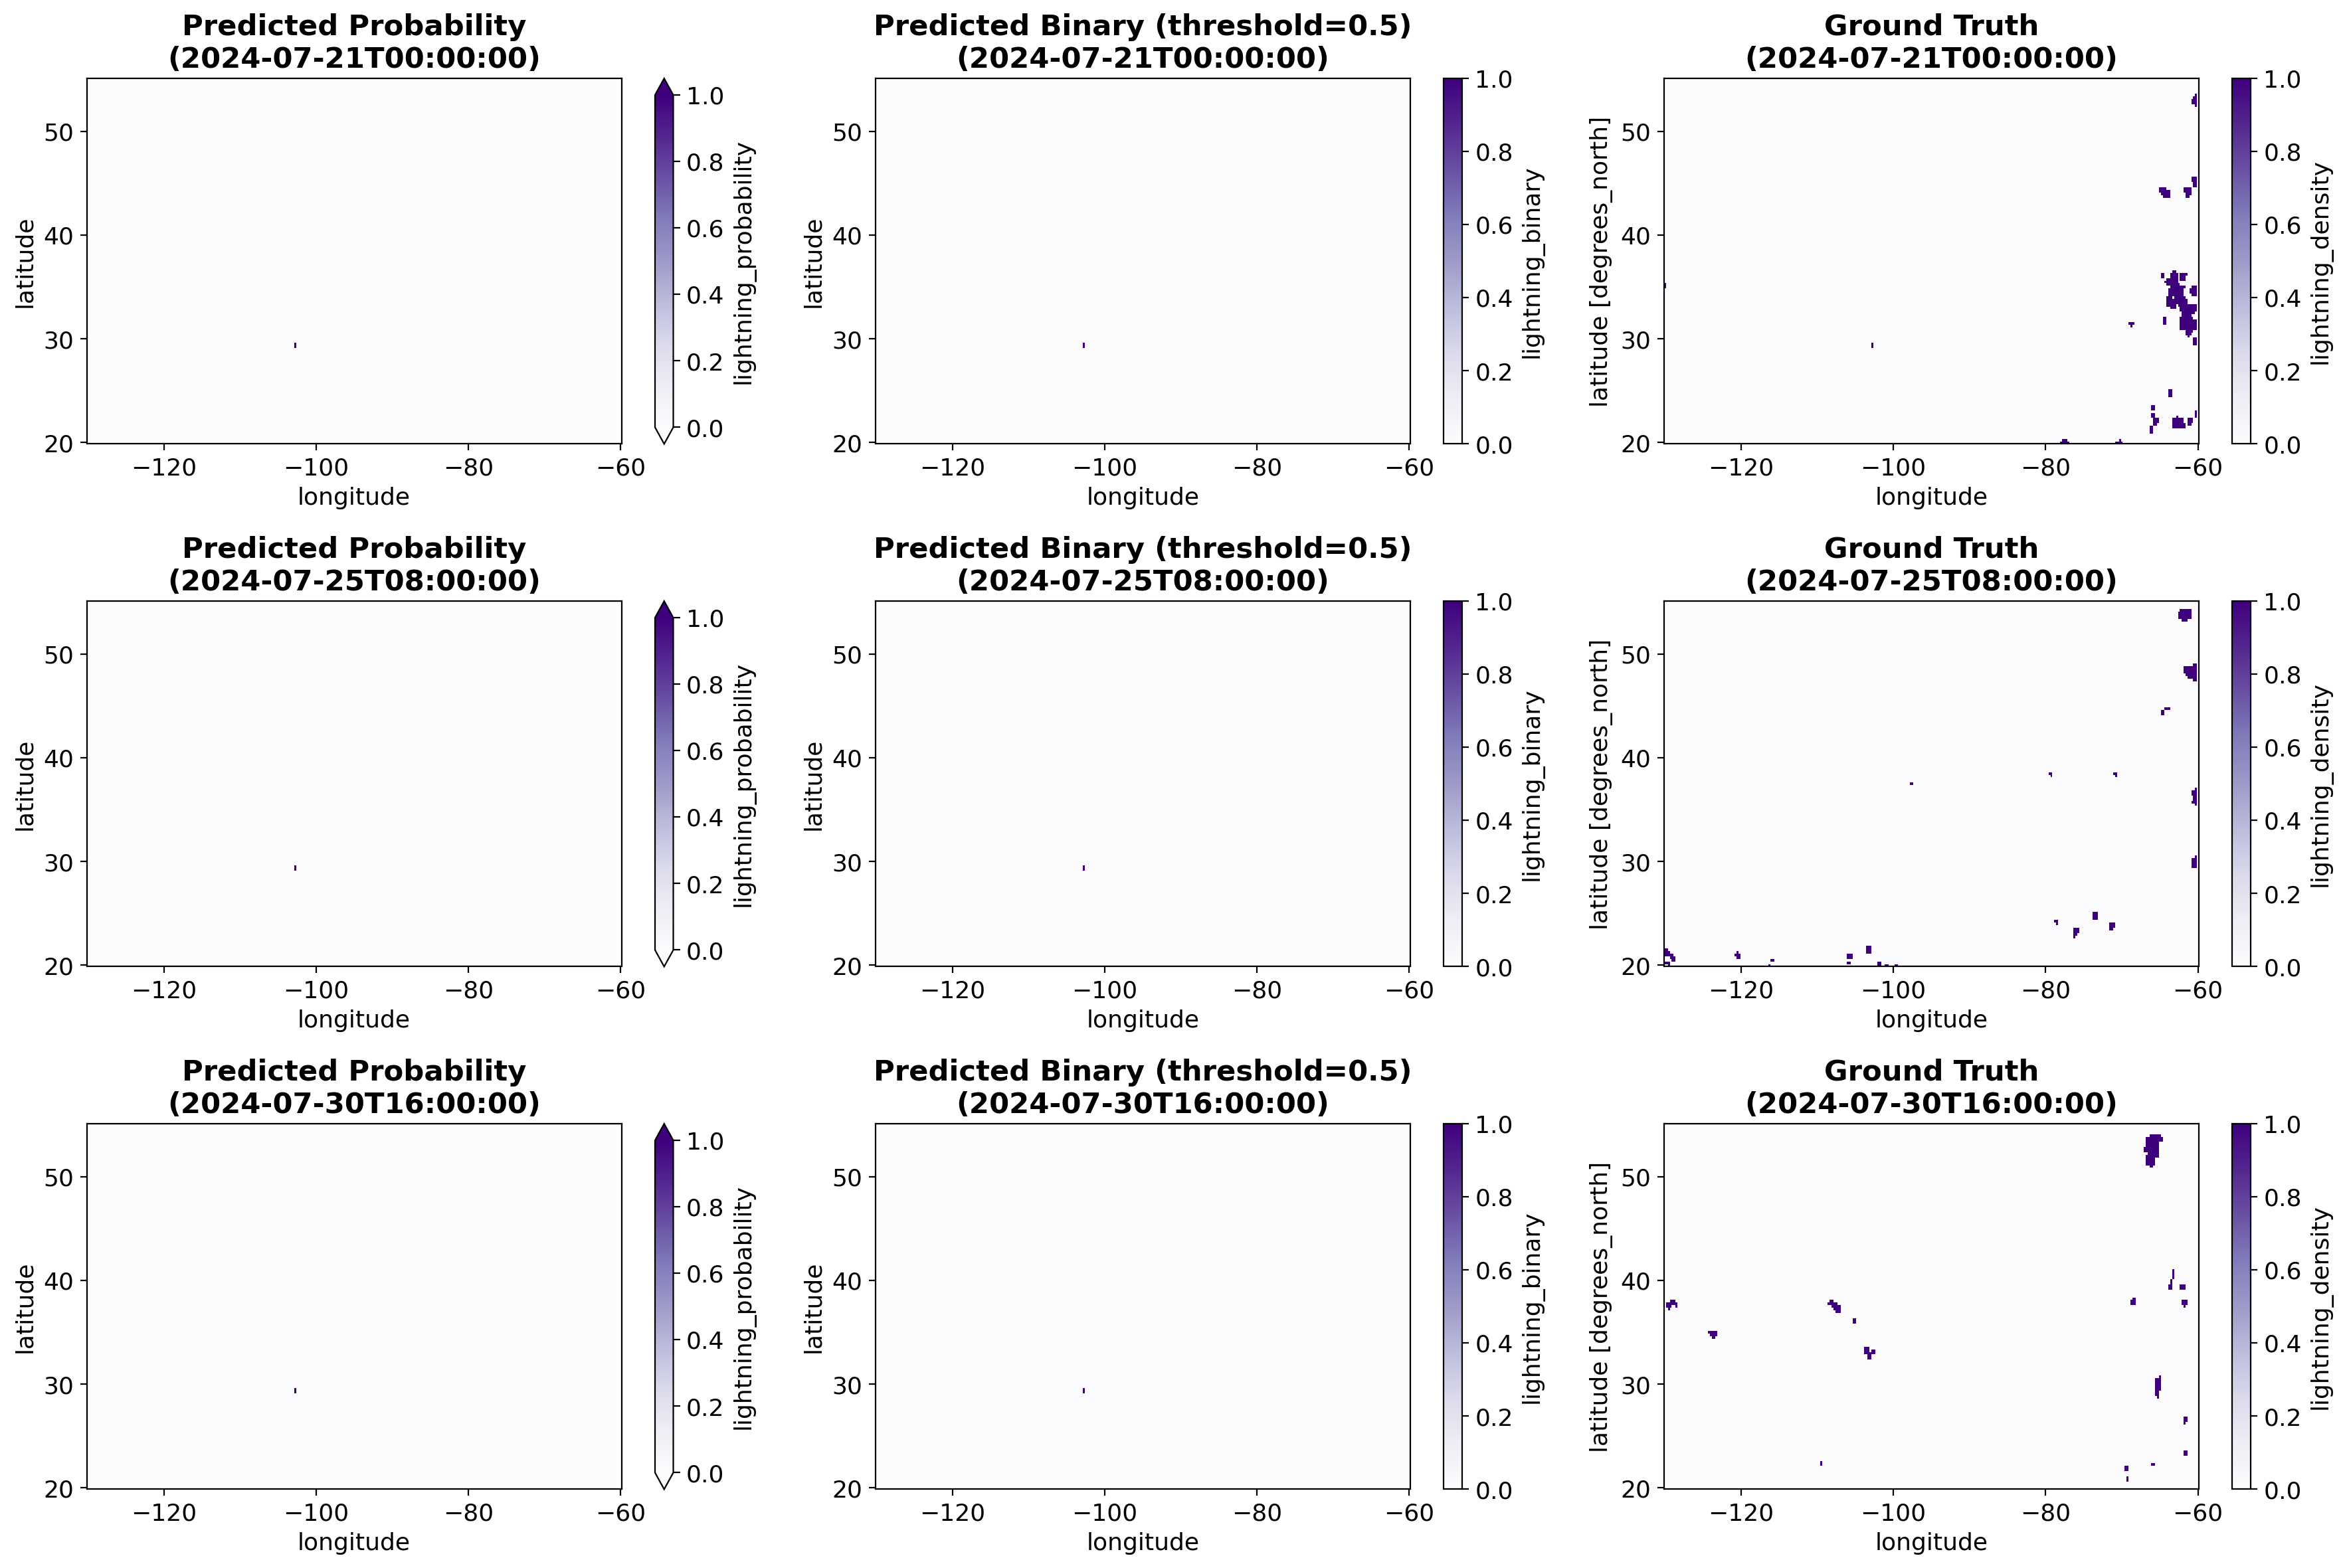

In [28]:
# ===== VISUALIZATIONS =====
fig, axes = plt.subplots(figsize=(18, 12), ncols=3, nrows=3)

yrs = ['2024-07-21T00:00:00', '2024-07-25T08:00:00', '2024-07-30T16:00:00']
vmin, vmax = 0, 1
cmap = 'Purples'

for i, yr in enumerate(yrs):
    # Predicted probability
    y_test_pred_xr.lightning_probability.sel(time=yr).plot(
        ax=axes[i, 0], vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True
    )
    axes[i, 0].set_title(f'Predicted Probability\n({yr})', fontweight='bold')
    
    # Predicted binary (threshold=0.5)
    y_test_pred_xr.lightning_binary.sel(time=yr).plot(
        ax=axes[i, 1], vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True
    )
    axes[i, 1].set_title(f'Predicted Binary (threshold={threshold})\n({yr})', fontweight='bold')
    
    # Ground truth (binary)
    y_test_binary_xr.sel(time=yr).plot(
        ax=axes[i, 2], vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True
    )
    axes[i, 2].set_title(f'Ground Truth\n({yr})', fontweight='bold')

plt.tight_layout()
plt.savefig('nn_predictions_spatial.png', dpi=150, bbox_inches='tight')
print("\nSaved spatial predictions to 'nn_predictions_spatial.png'")

Then we also check whether the ML model can reproduce the time series of a given location.

Saved time series to 'nn_predictions_timeseries.png'


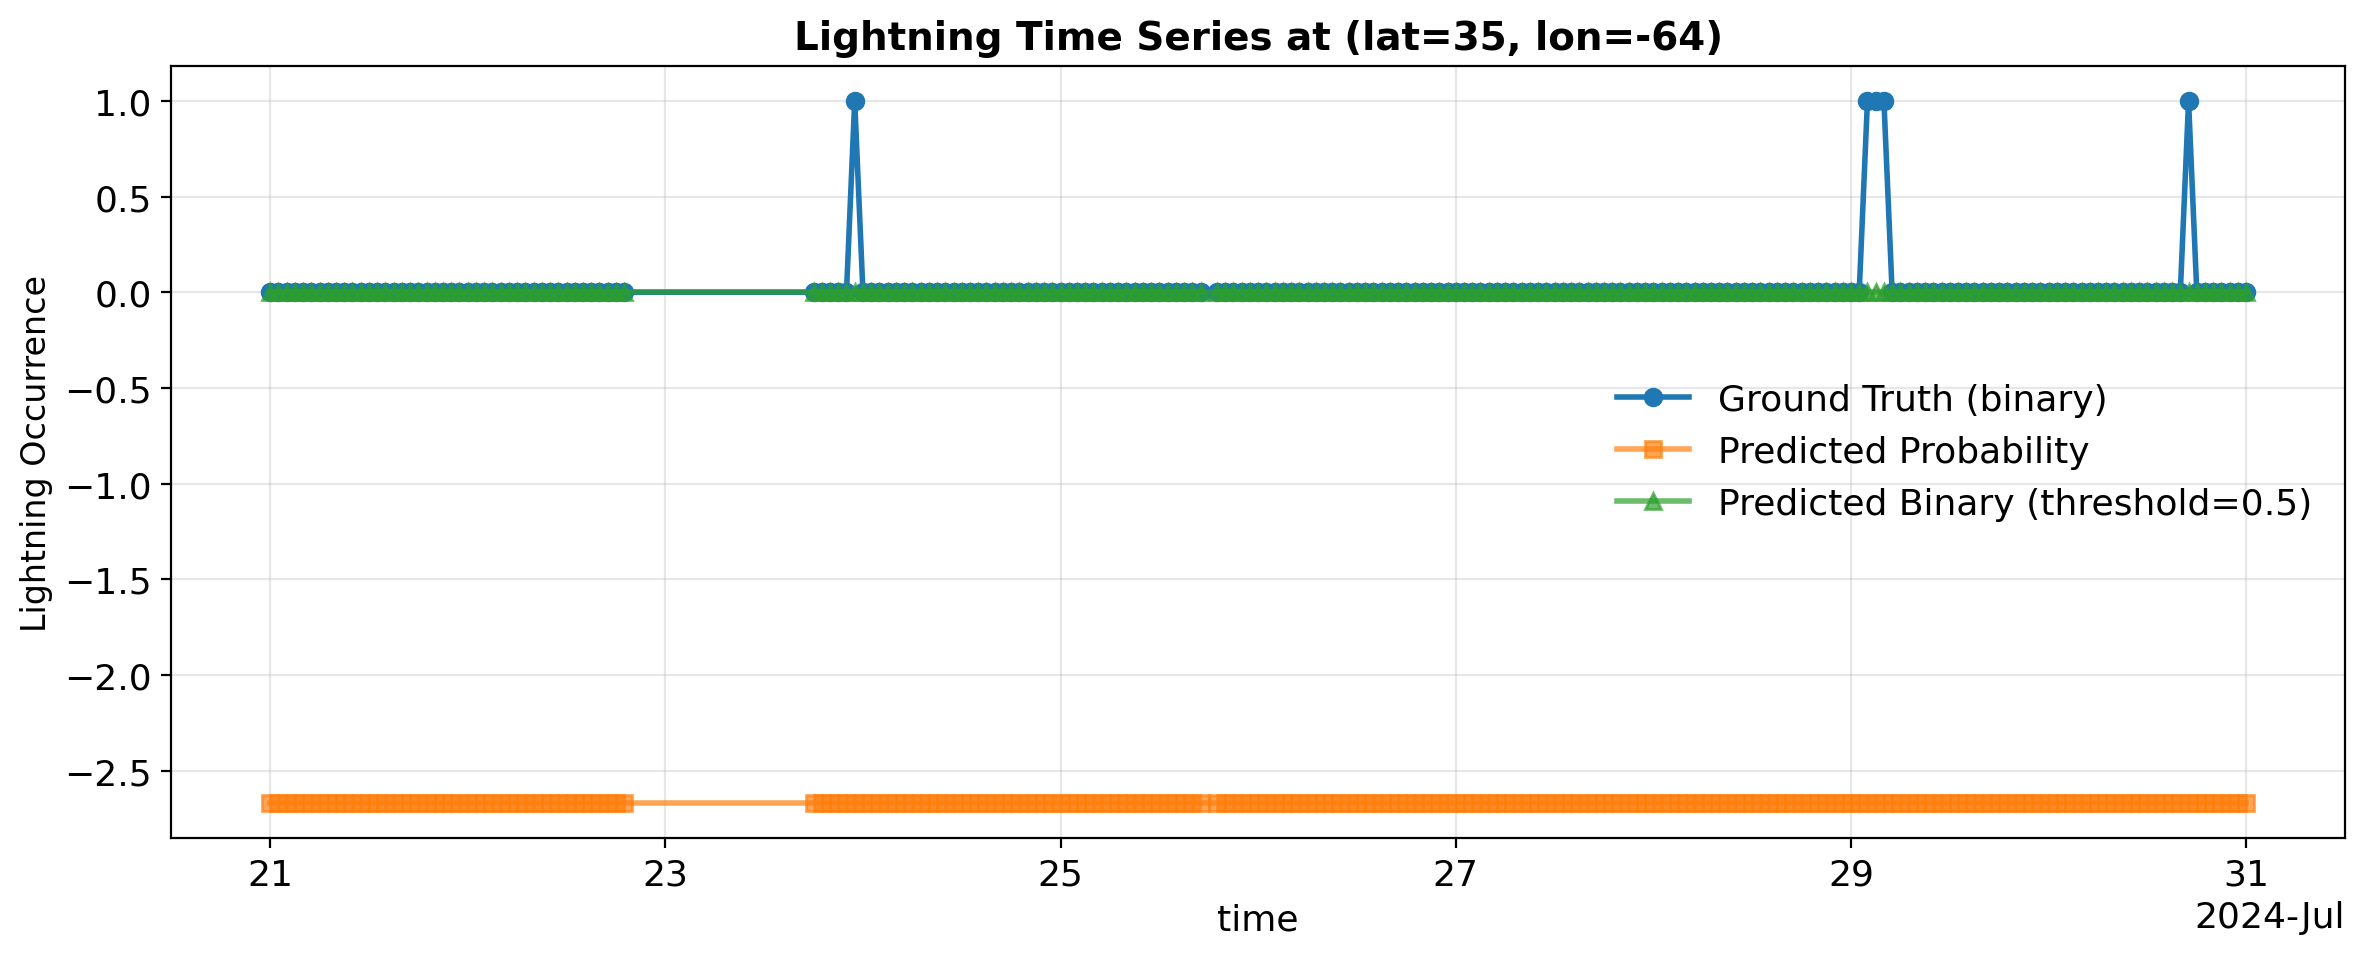

In [21]:
# Time series at specific location
lat = 35
lon = -64

fig, ax = plt.subplots(figsize=(12, 5))
y_test_binary_xr.sel(latitude=lat, longitude=lon, method='nearest').plot(
    marker='o', ax=ax, label='Ground Truth (binary)', linewidth=2
)
y_test_pred_xr.sel(latitude=lat, longitude=lon, method='nearest').lightning_probability.plot(
    marker='s', ax=ax, label='Predicted Probability', linewidth=2, alpha=0.7
)
y_test_pred_xr.sel(latitude=lat, longitude=lon, method='nearest').lightning_binary.plot(
    marker='^', ax=ax, label=f'Predicted Binary (threshold={threshold})', linewidth=2, alpha=0.7
)

ax.legend()
ax.set_ylabel('Lightning Occurrence', fontsize=12)
ax.set_title(f'Lightning Time Series at (lat={lat}, lon={lon})', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('nn_predictions_timeseries.png', dpi=150, bbox_inches='tight')
print("Saved time series to 'nn_predictions_timeseries.png'")